In [10]:
import os
import tensorflow as tf

# If there are multiple GPUs and we only want to use one/some, set the number in the visible device list.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

### **1. Loading the dataset**
This assignment will focus on the CIFAR10 dataset. This is a collection of small images in 10 classes such as cars, cats, birds, etc. You can find more information here: https://www.cs.toronto.edu/~kriz/cifar.html. We start by loading and examining the data.

In [11]:
import numpy as np
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


#### **<span style="color:red">Question 1:</span>**
The shape of X_train and X_test has 4 values. What do each of these represent?

##### **Plotting some images**
This plots a random selection of images from each class. Rerun the cell to see a different selection.

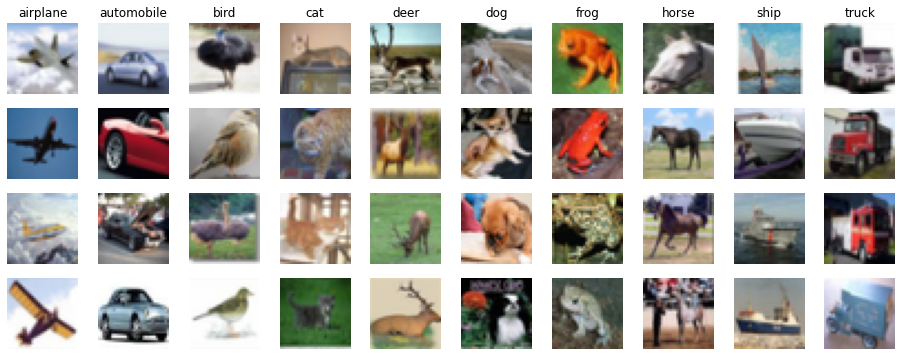

In [12]:
from Custom import PlotRandomFromEachClass

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
PlotRandomFromEachClass(X_train, y_train, 4, labels=cifar_labels)

##### **Preparing the dataset**
Just like the MNIST dataset we normalize the images to [0,1] and transform the class indices to one-hot encoded vectors.

**The ideal machine learning model is end-to-end.** 

In general, you should seek to do data preprocessing as part of your model as much as possible, not via an external data preprocessing pipeline. That's because external data preprocessing makes your models less portable when it's time to use them in production. Consider a model that processes text: it uses a specific tokenization algorithm and a specific vocabulary index. When you want to ship your model to a mobile app or a JavaScript app, you will need to recreate the exact same preprocessing setup in the target language. This can get very tricky: any small discrepancy between the original pipeline and the one you recreate has the potential to completely invalidate your model, or at least severely degrade its performance.

**It would be much easier to be able to simply export an end-to-end model that already includes preprocessing. The ideal model should expect as input something as close as possible to raw data: an image model should expect RGB pixel values in the [0, 255] range, and a text model should accept strings of utf-8 characters. That way, the consumer of the exported model doesn't have to know about the preprocessing pipeline.**

In [13]:
from tensorflow.keras.utils import to_categorical

# Transform label indices to one-hot encoded vectors
y_train_c = to_categorical(y_train, num_classes=10)
y_test_c  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

### **2. Fully connected classifier**
We will start by creating a fully connected classifier using the ```Dense``` layer. We give you the first layer that flattens the image features to a single vector. Add the remaining layers to the network.

Consider what the size of the output must be and what activation function you should use in the output layer.

A "layer" is a simple input-output transformation (such as the scaling & center-cropping transformations above). 

A "model" is a directed acyclic graph of layers. You can think of a model as a "bigger layer" that encompasses multiple sublayers and that can be trained via exposure to data.

The most common and most powerful way to build Keras models is the Functional API. To build models with the Functional API, you start by specifying the shape (and optionally the dtype) of your inputs. If any dimension of your input can vary, you can specify it as None. For instance, an input for 200x200 RGB image would have shape (200, 200, 3), but an input for RGB images of any size would have shape (None, None, 3).

In [79]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate
from tensorflow import keras

x_in = Input(shape=X_train.shape[1:])
x = Flatten()(x_in)

# === Add your code here ===
x = Dense(80, activation="relu")(x)
a = Dense(80, activation="tanh")(x)
x = Dense(70, activation="relu")(a)
y = Dense(80, activation="relu")(x)
b = Dense(64, activation="relu")(y)
x = Dense(64, activation="tanh")(b)
x = concatenate([a,b])
x = Dense(10, activation="softmax")(x)
# ==========================

model = Model(inputs=x_in, outputs=x)

# Now we build the model using Stochastic Gradient Descent with Nesterov momentum. We use accuracy as the metric.
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(100)

Model: "functional_36"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            [(None, 32, 32, 3)]   0                                            
____________________________________________________________________________________________________
flatten_21 (Flatten)             (None, 3072)          0           input_22[0][0]                   
____________________________________________________________________________________________________
dense_153 (Dense)                (None, 80)            245840      flatten_21[0][0]                 
____________________________________________________________________________________________________
dense_154 (Dense)                (None, 80)            6480        dense_153[0][0]                  
____________________________________________________________________

##### **Training the model**
In order to show the differences between models in the first parts of the assignment, we will restrict the training to the following command using 15 epochs, batch size 32, and 20% validation data. From section 5 and forward you can change this as you please to increase the accuracy, but for now stick with this command.

In [80]:
history = model.fit(X_train,y_train_c, epochs=15, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.8405 - accuracy: 0.3304 - val_loss: 1.7144 - val_accuracy: 0.3852
Epoch 2/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6903 - accuracy: 0.3907 - val_loss: 1.6803 - val_accuracy: 0.3961
Epoch 3/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6293 - accuracy: 0.4140 - val_loss: 1.6334 - val_accuracy: 0.4116
Epoch 4/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5924 - accuracy: 0.4250 - val_loss: 1.6338 - val_accuracy: 0.4118
Epoch 5/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5620 - accuracy: 0.4363 - val_loss: 1.6104 - val_accuracy: 0.4284
Epoch 6/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5404 - accuracy: 0.4440 - val_loss: 1.5686 - val_accuracy: 0.4386
Epoch 7/15
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5186 - accuracy: 0.4562 - val_loss: 1.6064 - val_accuracy:

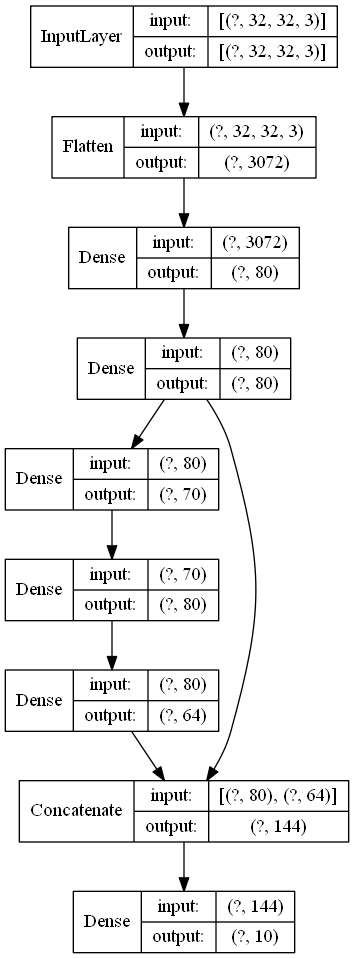

In [81]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

##### **Evaluating the model**
We use ```model.evaluate``` to get the loss and metric scores on the test data. To plot the results we give you a custom function that does the work for you.

In [82]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 1.517
Test accuracy = 0.463


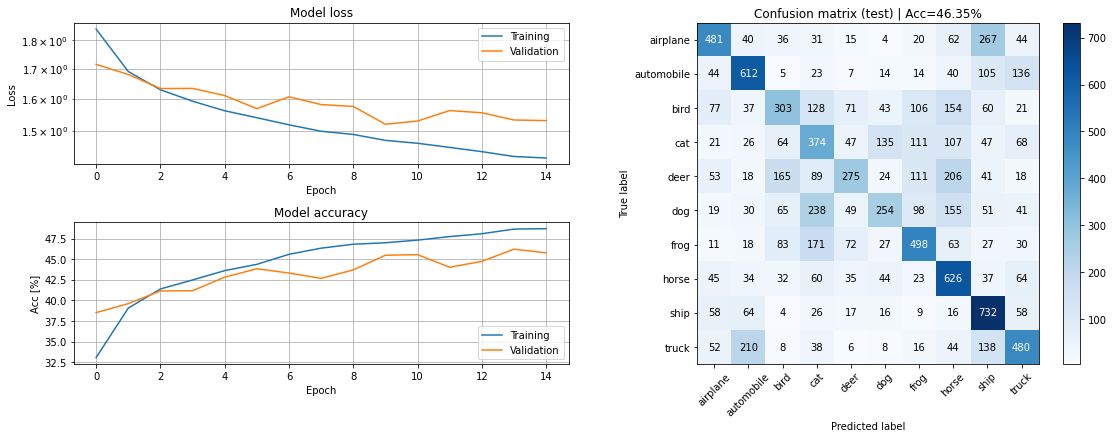

In [83]:
from Custom import PlotModelEval

# Custom function for evaluating the model and plotting training history
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 2:</span>**
Train a model that achieves above 45% accuracy on the test data. In the report, provide a (short) description of your model and show the evaluation image.

#### **<span style="color:red">Question 3:</span>**
Compare this model to the one you used for the MNIST dataset in the first assignment, in terms of size and test accuracy. Why do you think this dataset is much harder to classify than the MNIST handwritten digits?

### **3. CNN classifier**
We will now move on to a network architecture that is more suited for this problem, the convolutional neural network. The new layers you will use are ```Conv2D``` and ```MaxPooling2D```, which you can find the documentation of here https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D and here https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D.

##### **Creating the CNN model**

A common way to build convolutional neural networks is to create blocks of layers of the form **[convolution - activation - pooling]**, and then stack several of these block to create the full convolution stack. This is often followed by a fully connected network to create the output classes. Use this recipe to build a CNN that acheives at least 62% accuracy on the test data.

*Side note. Although this is a common way to build CNNs, it is be no means the only or even best way. It is a good starting point, but later in part 5 you might want to explore other architectures to acheive even better performance.*

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

x_in = Input(shape=X_train.shape[1:])

# === Add your code here ===

# ==========================

model = Model(inputs=x_in, outputs=x)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

##### **Training the CNN**

In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

##### **Evaluating the CNN**

In [ ]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 4:</span>**
Train a model that achieves at least 62% test accuracy. In the report, provide a (short) description of your model and show the evaluation image.

#### **<span style="color:red">Question 5:</span>**
Compare this model with the previous fully connected model. You should find that this one is much more efficient, i.e. achieves higher accuracy with fewer parameters. Explain in your own words how this is possible.

### **4. Regularization**

#### **4.1 Dropout**
You have probably seen that your CNN model overfits the training data. One way to prevent this is to add ```Dropout``` layers to the model, that randomly "drops" hidden nodes each training-iteration by setting their output to zero. Thus the model cannot rely on a small set of very good hidden features, but must instead learns to use different sets of hidden features each time. Dropout layers are usually added after the pooling layers in the convolution part of the model, or after activations in the fully connected part of the model.

*Side note. In the next assignment you will work with Ensemble models, a way to use the output from several individual models to achieve higher performance than each model can achieve on its own. One way to interpret Dropout is that each random selection of nodes is a separate model that is trained only on the current iteration. The final output is then the average of outputs from all the individual models. In other words, Dropout can be seen as a way to build ensembling directly into the network, without having to train several models explicitly.*

Extend your previous model with the Dropout layer and test the new performance.

In [ ]:
from tensorflow.keras.layers import Dropout

x_in = Input(shape=X_train.shape[1:])

# === Add your code here ===

# ==========================

model = Model(inputs=x_in, outputs=x)

# Compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 6:</span>**
Train the modified CNN-model. Save the evaluation image for the report.

#### **<span style="color:red">Question 7:</span>**
Compare this model and the previous in terms of the training accuracy, validation accuracy, and test accuracy. Explain the similarities and differences (remember that the only difference between the models should be the addition of Dropout layers).

Hint: what does the dropout layer do at test time?

#### **4.2 Batch normalization**
The final layer we will explore is ```BatchNormalization```. As the name suggests, this layer normalizes the data in each batch to have a specific mean and standard deviation, which is learned during training. The reason for this is quite complicated (and still debated among the experts), but suffice to say that it helps the optimization converge faster which means we get higher performance in fewer epochs. The normalization is done separatly for each feature, i.e. the statistics are calculated accross the batch dimension of the input data. The equations for batch-normalizing one feature are the following, where $N$ is the batch size, $x$ the input features, and $y$ the normalized output features:

$$ \mu = \frac{1}{N} \sum_{i=0}^{N}x_i,\;\;\;\; \sigma^2 = \frac{1}{N} \sum_{i=0}^{N}(x_i - \mu)^2 $$

$$ \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} $$

$$ y_i = \gamma \hat{x}_i + \beta $$

At first glance this might look intimidating, but all it means is that we begin by scaling and shifting the data to have mean $\mu=0$ and standard deviation $\sigma=1$. After this we use the learnable parameters $\gamma$ and $\beta$ to decide the width and center of the final distribution. $\epsilon$ is a small constant value that prevents the denominator from being zero.

In addition to learning the parameters $\gamma$ and $\beta$ by gradient decent just like the weights, Batch Normalization also keeps track of the running average of minibatch statistics $\mu$ and $\sigma$. These averages are used to normalize the test data. We can tune the rate at which the running averages are updated with the *momentum* parameter of the BatchNormalization layer. A large momentum means that the statistics converge more slowly and therefore requires more updates before it represents the data. A low momentum, on the other hand, adapts to the data more quickly but might lead to unstable behaviour if the latest minibatches are not representative of the whole dataset. For this test we recommend a momentum of 0.75, but you probably want to change this when you design a larger network in Section 5.

The batch normalization layer should be added after the hidden layer linear transformation, but before the nonlinear activation. This means that we cannot specify the activation funciton in the ```Conv2D``` or ```Dense``` if we want to batch-normalize the output. We therefore need to use the ```Activation``` layer to add a separate activation to the network stack after batch normalization. For example, the convolution block will now look like **[conv - batchnorm - activation - pooling]**.

Extend your previous model with batch normalization, both in the convolution and fully connected part of the model.

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Activation

x_in = Input(shape=X_train.shape[1:])

# === Add your code here ===

# ==========================

model = Model(inputs=x_in, outputs=x)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 8:</span>**
Train the model and save the evaluation image for the report.

#### **<span style="color:red">Question 9:</span>**
When using BatchNorm one must take care to select a good minibatch size. Describe what problems might arise if the wrong minibatch size is used.

You can reason about this given the description of BatchNorm above, or you can search for the information in other sources. Do not forget to provide links to the sources if you do!

### **5. Putting it all together**
We now want you to create your own model based on what you have learned. We want you to experiment and see what works and what doesn't, so don't go crazy with the number of epochs until you think you have something that works.

To pass this assignment, we want you to acheive **75%** accuracy on the test data in no more than **25 epochs**. This is possible using the layers and techniques we have explored in this notebook, but you are free to use any other methods that we didn't cover. (You are obviously not allowed to cheat, for example by training on the test data.)

In [ ]:
from tensorflow.keras.utils import plot_model

x_in = Input(shape=X_train.shape[1:])

# === Add your code here ===

# ==========================

model = Model(inputs=x_in, outputs=x)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **<span style="color:red">Question 10:</span>**
Design and train a model that achieves at least 75% test accuracy in at most 25 epochs. Save the evaluation image for the report. Also, in the report you should explain your model and motivate the design choices you have made.

### **Want some extra challenge?**
For those of you that feel the competitive spark right now, we will hold an **optional** competition where you can submit your trained model-file for evaluation. To make this fair, you are not allowed to train for more than **50 epochs**, but other than that we want you to get creative. The competition is simple, we will evaluate all submitted models and the model with highest test accuracy wins. The prize is nothing less than eternal glory.

Here are some things to look into, but note that we don't have the answers here. Any of these might improve the performance, or might not, or it might only work in combination with each other. This is up to you to figure out. This is how deep learning research often happens, trying things in a smart way to see what works best.
* Tweak or change the optimizer or training parameters.
* Tweak the filter parameters, such as numbers and sizes of filters.
* Use other activation functions.
* Add L1/L2 regularization (see https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
* Include layers that we did not cover here (see https://www.tensorflow.org/api_docs/python/tf/keras/layers). For example, our best model uses the global pooling layers.
* Take inspiration from some well-known architectures, such as ResNet or VGG16. (But don't just copy-paste those architectures. For one, what's the fun in that? Also, they take a long time to train, you will not have time.)
* Use explicit model ensembing (training multiple models that vote on or average the outputs - this will also take a lot of time.)
* Use data augmentation to create a larger training set (see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Write your competition model here. This way you can try different things without deleting the model you created above. Also set the GroupName variable to your LiU IDs or some unique name; that way our scripts can be a lot easier, thanks and good luck :)

In [ ]:
GroupName = "Test"

x_in = Input(shape=X_train.shape[1:])

# Your code here

model = Model(inputs=x_in, outputs=x, name=GroupName)

# You can also change this if you want
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

# Print the summary and model image
model.summary(100)
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

In [ ]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

**Don't forget to save your model!**

In [ ]:
model.save("CompetionModel_" + GroupName + ".h5")